# Quickstart: Spring–Slider with Slip-Weakening Friction

This notebook demonstrates solving a 1-DOF spring–slider system with a nonsmooth friction constraint using two solver strategies (VI and Semismooth Newton), with optional Numba acceleration, and compares against a regularized smooth BDF baseline plus an analytical (piecewise Coulomb) reference when parameters match.

**Focus**
- High-level convenience API `solve_ivp_ns` vs repeated calls for variants.
- Projection Jacobian: analytical vs finite-difference.
- Globalization (Armijo line search) impact.
- Performance and accuracy comparisons.

**Run order**
1. Parameters & system definitions.
2. Friction law & constraint functions.
3. Solve with VI (Projected iteration) via `solve_ivp_ns`.
4. Semismooth Newton (Python & Numba paths).
5. BDF reference (regularized smooth).
6. Analytical solution (optional if parameters match assumptions).
7. Plotting & performance summary.
8. Globalization & Jacobian demos (optional deep dive).

Estimated runtime: ~1–2 minutes (Numba JIT may add a one-time warmup).

---

# Spring-Slider Element Tutorial

In this tutorial, we demonstrate how to simulate a spring-slider system using different numerical integration methods. We will:
  
- Define the system parameters (mass, stiffness, damping, friction, etc.).
- Set up the ordinary differential equation (ODE) model for the spring-slider.
- Solve the ODE using SciPy's BDF method as well as custom non-smooth solvers (VI and semismooth Newton) from our `Solve_IVP_NS` module.
- Compare the numerical solutions with an analytical solution (provided by a function `piecewise_coulomb`).
- Visualize the results and compare runtimes.



# Import Dependencies

## Residual (`fk`) Meaning
Each accepted step returns `fk` capturing the raw implicit residual prior to projection satisfaction. Inspecting norms of `fk` helps:
- Compare solver tightness (VI may leave larger intermediate residuals).
- Diagnose convergence stalls (plateauing norms).
To log residual norms inline, you can augment the solver loop or post-process `fk_vals_*` arrays.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp

# Import your custom solver module.
# Replace the following import with the actual location of Solve_IVP_NS.
# For example, if your module is in the same directory, you might do:
# from Solve_IVP_NS import solve_ivp_ns
import Solve_IVP_NS  # Ensure that this module is in your PYTHONPATH

# If you have an analytical solution function, import or define it.
# For this tutorial, we assume piecewise_coulomb is defined elsewhere.
from analytical import solve_damped_constant_offset, piecewise_coulomb


# Physical parameters

In [84]:
# Physical parameters
mass = 2.0       # Slider mass [kg]
k = 1.0          # Spring stiffness [N/m]
zeta = 1.0       # Damping ratio
N = 1.0          # Normal force [N]  NOTE: TO PERFORM NONCONSTRAINED SIMULATION SET TO ZERO
v0 = 0.1         # Initial velocity [m/s]

# Friction parameters
Dc = 0.1         # Critical slip distance [m]
mu_res = 0.6     # Residual friction coefficient
Dmu = 0.1*0        # Friction coefficient drop NOTE: set to zero to compare with analytical solution

# Numerical parameters 
epsilon = 1e-12  # Regularization parameter for solve_ivp comparison NOTE: eps>1e-12 may not converge 
t_span = (0, 1) # Simulation time window

## System Configuration

In [85]:
I = np.eye(1)
Ma = np.array([[mass]])
K = np.array([[k]])
E = 2 * zeta * K

# State is [v, s] (no auxiliary z)
# Block matrix A: first block for velocities (with mass M), second for displacements (I)
A = np.block([
    [np.array([[mass]]),               np.zeros((1, 1)) ],
    [np.zeros((1, 1)),                 I               ]
])


# Dynamical System

In [86]:
def rhs_regularized(t, y):
    """ODE for BDF solver with regularized friction (state [v, s])"""
    v = y[0:1]
    s = y[1:2]
    v_dot = (- K @ s - E @ v - friction_force(y)) / mass
    s_dot = v
    return np.concatenate([v_dot, s_dot])


def rhs(t, y):
    """Smooth rhs (for projection and SSN methods), state [v, s]"""
    # print(f'the new time is: {t}')
    v = y[0:1]
    s = y[1:2]
    v_dot = - K @ s - E @ v
    s_dot = v
    return np.concatenate([v_dot, s_dot])


In [87]:
# Analytical Jacobian of the smooth RHS: df/dy(t, y)
# State ordering: y = [v, s]
# rhs(t,y) = [ -K @ s - E @ v,
#              v ]
# For our 1-DOF scalar case, K, E are 1x1 arrays

def rhs_jacobian(t, y):
    # Build dense Jacobian matching rhs output size (2 x 2)
    J = np.zeros((2, 2))
    # dv_dot/dv = -E, dv_dot/ds = -K
    J[0, 0] = -E[0, 0]
    J[0, 1] = -K[0, 0]
    # ds_dot/dv = 1
    J[1, 0] = 1.0
    return J


# Friction

In [88]:
def regularized_sign(v):
    """Smooth approximation of sign function"""
    return np.tanh(v / epsilon)


def mu(y):
    """Slip-weakening friction law; y = [v, s]"""
    s = y[1]
    return mu_res * (1 - Dmu/mu_res * np.exp(-abs(s)/Dc))


def friction_force(y):
    """Regularized friction force; y = [v, s]"""
    v = y[0]
    return mu(y) * N * regularized_sign(v)


def con_force(y, t=None, Fk_val=None):
    """Friction constraint on velocity (returns vector same length as y)."""
    constraint = np.zeros_like(y)
    constraint[0] = mu(y) * N
    return constraint

# Analytical Jacobian of con_force(y): R^n -> R^n for n=2 here
# Only the first output depends on s = y[1].
# d(con_force[0])/ds = N * (Dmu/Dc) * sign(s) * exp(-|s|/Dc)
# Other partials are zero; other rows are zero.

def con_force_jacobian(y, t=None, Fk_val=None):
    J = np.zeros((2, 2))
    s = y[1]
    dmu_ds = (Dmu / Dc) * np.sign(s) * np.exp(-abs(s) / Dc)
    J[0, 1] = N * dmu_ds
    return J


# Solver setup and integration

In [89]:
y0 = np.array([v0, 0.0])  # initial condition [v, s]; no z
component_slices = [slice(0,1), slice(1,2)]  # [v], [s]

# projection and solver options
projection_opts = {
    'con_force_func': con_force,  # pass the friction constraint force
    'rhok': np.array([1.0, 1.0]),  # vector length matches state
    'component_slices': component_slices,
    'constraint_indices': [0],  # index of the constrained variable (v)
    'jac_func': con_force_jacobian,  # analytical Jacobian for CoulombProjection
}
solver_opts = {
    'tol': 1e-10,
    'max_iter': 100,
    # Provide analytical RHS Jacobian; integrators will build exact J_in
    'rhs_jac': rhs_jacobian,
    # Sparse tuning for large N
    'sparse': 'auto',
    'sparse_threshold': 200,
    'linear_solver': 'gmres',
    'gmres_tol': 1e-8,
    'gmres_maxiter': None,
    'gmres_restart': 50,
    'precond_reuse_steps': 10,
    'ilu_drop_tol': 1e-3,
    'ilu_fill_factor': 10.0,
    'splu_permc_spec': 'COLAMD',
    'ilu_permc_spec': 'COLAMD',
    'linear_tol_strategy': 'eisenstat',
    'eisenstat_c': 0.5,
    'eisenstat_exp': 0.5,
}

# ============== Solve with Projected Gradient ==============
tic_vi = time.time()
(t_vals_vi, y_vals_vi, h_vals_vi, fk_vals_vi, solver_info_vi) = Solve_IVP_NS.solve_ivp_ns(
    fun=rhs,
    t_span=t_span,
    y0=y0,
    method='composite',
    projection='coulomb',
    solver='VI',
    projection_opts=projection_opts,
    solver_opts=solver_opts,
    adaptive=True,
    atol=1e-6,
    rtol=1e-3,
    h0=0.01,
    component_slices=component_slices,
    verbose=True,
    A=A
)
print('Solve with PG succesful')
toc_vi = time.time() - tic_vi


coulomb


[adaptive] accept @ t=0 -> t+1.000e-02, E=3.692e-03, h_next=2.000e-02
[adaptive] accept @ t=0.01 -> t+2.000e-02, E=1.586e-02, h_next=4.000e-02
[adaptive] accept @ t=0.03 -> t+4.000e-02, E=6.838e-02, h_next=8.000e-02
[adaptive] accept @ t=0.07 -> t+8.000e-02, E=3.199e-01, h_next=1.600e-01
[adaptive] reject @ t=0.15, E=1.192e+01, h_curr=1.600e-01 -> h_next=9.600e-02
[adaptive] half-step fail #1 @ t=0.15
[adaptive] accept @ t=0.15 -> t+5.760e-02, E=1.020e-01, h_next=1.152e-01
[adaptive] reject @ t=0.2076, E=8.608e+00, h_curr=1.152e-01 -> h_next=6.912e-02
[adaptive] half-step fail #2 @ t=0.2076
[adaptive] accept @ t=0.2076 -> t+4.147e-02, E=3.988e-02, h_next=8.294e-02
[adaptive] reject @ t=0.249072, E=4.340e+00, h_curr=8.294e-02 -> h_next=4.977e-02
[adaptive] reject @ t=0.249072, E=1.576e+00, h_curr=4.977e-02 -> h_next=2.986e-02
[adaptive] accept @ t=0.249072 -> t+2.986e-02, E=3.815e-02, h_next=5.972e-02
[adaptive] accept @ t=0.278932 -> t+5.972e-02, E=7.205e-01, h_next=1.158e-01
[adaptive

In [90]:
# === Full semismooth Newton solves: pure Python vs Numba, plus BDF reference ===
# We run the full integrator twice, once forcing pure Python (use_numba=False)
# and once forcing Numba acceleration (use_numba=True). Then we also solve
# the regularized smooth problem with SciPy's BDF for comparison.

# Make a copy of base solver opts for semismooth Newton
solver_opts_ssn = solver_opts.copy()
solver_opts_ssn['max_iter'] = 100

# Projection options variants
projection_opts_py = dict(projection_opts)
projection_opts_py['use_numba'] = False  # force pure Python path

projection_opts_nb = dict(projection_opts)
projection_opts_nb['use_numba'] = True   # force Numba path

# --- Semismooth Newton (pure Python) ---
start_py = time.time()
(t_vals_ssn_py,
 y_vals_ssn_py,
 h_vals_ssn_py,
 fk_vals_ssn_py,
 solver_info_ssn_py) = Solve_IVP_NS.solve_ivp_ns(
    fun=rhs,
    t_span=t_span,
    y0=y0,
    method='composite',
    projection='coulomb',
    solver='semismooth_newton',
    projection_opts=projection_opts_py,
    solver_opts=solver_opts_ssn,
    adaptive=True,
    atol=1e-6,
    rtol=1e-3,
    h0=0.01,
    component_slices=component_slices,
    verbose=False,
    A=A
)
rt_py = time.time() - start_py
print(f"Semismooth (Python) solve complete in {rt_py:.3f} s")

# --- Semismooth Newton (Numba) ---
start_nb = time.time()
(t_vals_ssn_nb,
 y_vals_ssn_nb,
 h_vals_ssn_nb,
 fk_vals_ssn_nb,
 solver_info_ssn_nb) = Solve_IVP_NS.solve_ivp_ns(
    fun=rhs,
    t_span=t_span,
    y0=y0,
    method='composite',
    projection='coulomb',
    solver='semismooth_newton',
    projection_opts=projection_opts_nb,
    solver_opts=solver_opts_ssn,
    adaptive=True,
    atol=1e-6,
    rtol=1e-3,
    h0=0.01,
    component_slices=component_slices,
    verbose=False,
    A=A
)
rt_nb = time.time() - start_nb
print(f"Semismooth (Numba)  solve complete in {rt_nb:.3f} s")

# Keep backward-compatible variable names for downstream post-processing.
# We choose the Numba result as the primary (you can swap to *_py if you prefer).
t_vals_ssn = t_vals_ssn_nb
y_vals_ssn = y_vals_ssn_nb
h_vals_ssn = h_vals_ssn_nb
y_fk_vals_placeholder = fk_vals_ssn_nb  # not used directly, keep for clarity
fk_vals_ssn = fk_vals_ssn_nb

# --- SciPy BDF reference solve (regularized) ---
start_bdf = time.time()
sol_bdf = solve_ivp(
    rhs_regularized,
    t_span,
    y0,
    method='BDF',
    atol=1e-6,
    rtol=1e-3
)
rt_bdf = time.time() - start_bdf
print(f"BDF (regularized) solve complete in {rt_bdf:.3f} s")

print("\nRuntime summary:")
print(f"  Semismooth Python : {rt_py:.3f} s")
print(f"  Semismooth Numba  : {rt_nb:.3f} s  (speedup x{rt_py/rt_nb if rt_nb>0 else float('nan'):.2f})")
print(f"  BDF Regularized   : {rt_bdf:.3f} s")

# (Optional) quick sanity check of solution agreement between Python and Numba paths
if y_vals_ssn_py.shape == y_vals_ssn_nb.shape:
    diffs = np.linalg.norm(y_vals_ssn_py - y_vals_ssn_nb, axis=1)
    print(f"Max state difference (Python vs Numba semismooth): {diffs.max():.3e}")

coulomb


Semismooth (Python) solve complete in 0.958 s
coulomb
Semismooth (Numba)  solve complete in 0.854 s
BDF (regularized) solve complete in 0.201 s

Runtime summary:
  Semismooth Python : 0.958 s
  Semismooth Numba  : 0.854 s  (speedup x1.12)
  BDF Regularized   : 0.201 s
Max state difference (Python vs Numba semismooth): 0.000e+00


# Post processing

In [91]:
def get_acceleration_ns(t_vals, y_vals, fk_vals):
    # Evaluate the ODE at each time-step (state [v, s])
    rhs_values = np.array([rhs(t, y) for t, y in zip(t_vals, y_vals)])
    # rhs_values shape: (Nsteps, 2); fk_vals shape aligns except first
    F = rhs_values[1:] + fk_vals
    Ainv = np.linalg.inv(A)
    acc_array = F @ Ainv
    return acc_array


def get_acceleration_sivp(t_vals, y_vals):
    rhs_values = np.array([rhs_regularized(t, y) for t, y in zip(t_vals, y_vals)])
    return rhs_values[:, 0]

# Acceleration for regularized BDF solution
acc_solv_ivp = get_acceleration_sivp(sol_bdf.t, sol_bdf.y.T)
# Acceleration for projected gradient solution
acc_vi = get_acceleration_ns(t_vals_vi, y_vals_vi, fk_vals_vi)
# Semismooth Newton accelerations (Python and Numba)
acc_ssn_py = get_acceleration_ns(t_vals_ssn_py, y_vals_ssn_py, fk_vals_ssn_py)
acc_ssn_nb = get_acceleration_ns(t_vals_ssn_nb, y_vals_ssn_nb, fk_vals_ssn_nb)
# Backward compatible name points to Numba version
acc_ssn = acc_ssn_nb


# Analytical Solution

In [92]:
# Call piecewise_coulomb with matching t_end(same as your t_span)
# so you can compare them directly.  E.g.:
c_val = 2.0 * zeta * K[0,0]  
k_val = K[0,0]
t_ana, s_ana, v_ana, a_ana = piecewise_coulomb(
    m=mass, 
    c=c_val,
    k=k_val,
    mu_res=mu_res,
    s0=0.0,
    v0=v0,
    t_end=t_span[1],
    n_steps=300
)

# Plotting

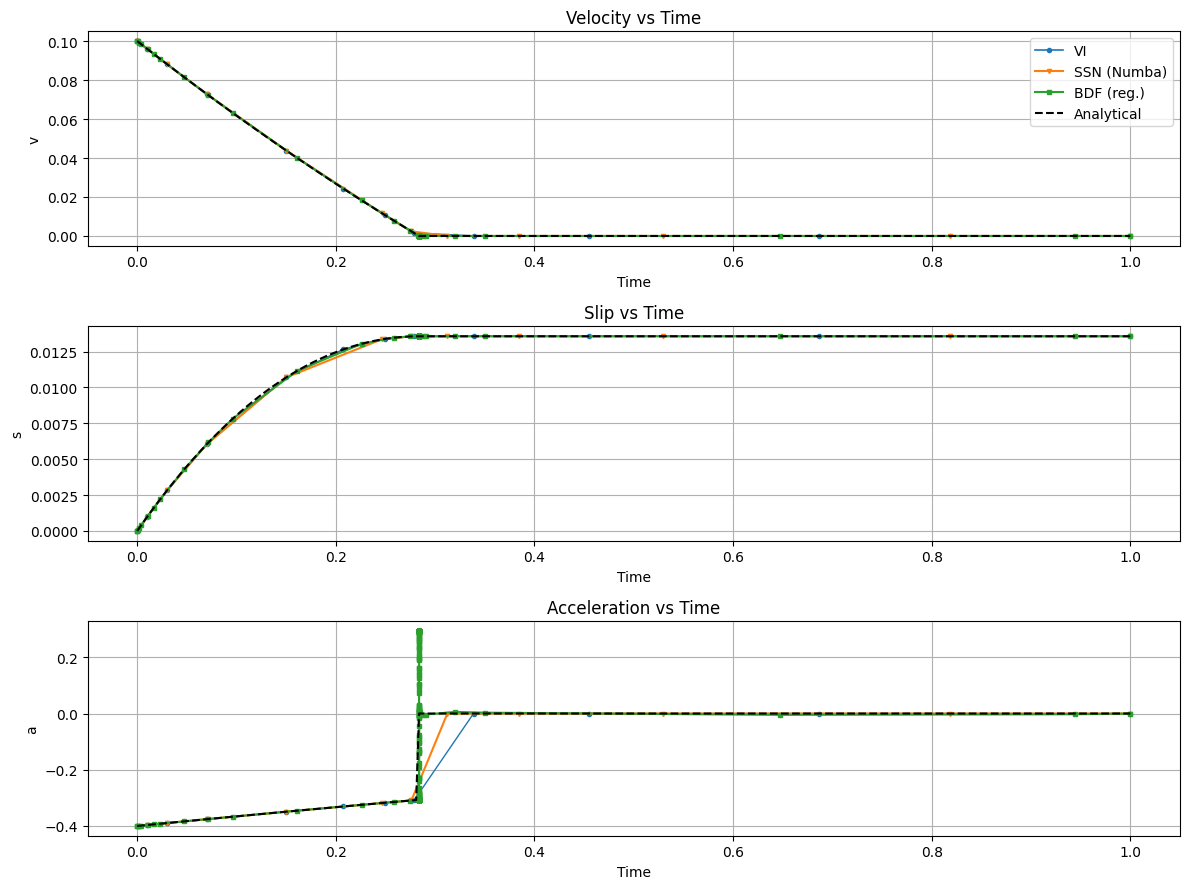

In [93]:
# ============== Plotting ==============
plt.figure(figsize=(12, 9))

# Velocity plot
plt.subplot(3,1,1)
plt.plot(t_vals_vi, y_vals_vi[:,0], "o-", label="VI", lw=1.2, ms=3)
# plt.plot(t_vals_ssn_py, y_vals_ssn_py[:,0], "^-", label="SSN (Py)", ms=3)
plt.plot(t_vals_ssn_nb, y_vals_ssn_nb[:,0], "v-", label="SSN (Numba)", ms=3)
plt.plot(sol_bdf.t, sol_bdf.y[0], "s-", label="BDF (reg.)", ms=3)
plt.plot(t_ana, v_ana, "k--", label="Analytical")
plt.title("Velocity vs Time")
plt.legend(); plt.grid(); plt.xlabel("Time"); plt.ylabel("v")

# Slip plot
plt.subplot(3,1,2)
plt.plot(t_vals_vi, y_vals_vi[:,1], "o-", lw=1.2, ms=3)
plt.plot(t_vals_ssn_nb, y_vals_ssn_nb[:,1], "v-", ms=3)
plt.plot(sol_bdf.t, sol_bdf.y[1], "s-", ms=3)
plt.plot(t_ana, s_ana, "k--")
plt.title("Slip vs Time")
plt.grid(); plt.xlabel("Time"); plt.ylabel("s")

# Acceleration plot
plt.subplot(3,1,3)
plt.plot(t_vals_vi[1:], acc_vi[:,0], "o-", lw=1.0, ms=3)
plt.plot(t_vals_ssn_nb[1:], acc_ssn_nb[:,0], "v-", ms=3)
plt.plot(sol_bdf.t, acc_solv_ivp, "s-", ms=3)
plt.plot(t_ana, a_ana, "k--")
plt.title("Acceleration vs Time")
plt.grid(); plt.xlabel("Time"); plt.ylabel("a")

plt.tight_layout()
plt.show()
